In [235]:
import xarray as xa

import numpy as np
import os
from scipy import interpolate

import matplotlib as mpl
from netCDF4 import num2date, date2num
import datetime

In [236]:
filein = '/Users/bell/ecoraid/2018/Moorings/18bsitaepr2a/initial_archive/erddap/'

In [237]:
file_names = [fn for fn in os.listdir(filein)
              if any(fn.endswith(ext) for ext in ['.nc'])]

In [238]:
data_dic = {}

for file in sorted(file_names):
    xdf = xa.open_dataset(filein+file)
    data_dic[int(file[-7:-3])] = {'Depth':xdf.Depth.data,'Chl':xdf.Chlorophyll.data,'Temp':xdf.Temperature.data,'DateTime':xdf.time.data}
    print(file)

18bsitaepr2a_p0003.nc
18bsitaepr2a_p0004.nc
18bsitaepr2a_p0005.nc
18bsitaepr2a_p0006.nc
18bsitaepr2a_p0007.nc
18bsitaepr2a_p0008.nc
18bsitaepr2a_p0009.nc
18bsitaepr2a_p0010.nc
18bsitaepr2a_p0011.nc
18bsitaepr2a_p0012.nc
18bsitaepr2a_p0013.nc
18bsitaepr2a_p0014.nc
18bsitaepr2a_p0015.nc
18bsitaepr2a_p0016.nc
18bsitaepr2a_p0017.nc
18bsitaepr2a_p0018.nc
18bsitaepr2a_p0019.nc
18bsitaepr2a_p0020.nc
18bsitaepr2a_p0021.nc
18bsitaepr2a_p0022.nc
18bsitaepr2a_p0023.nc
18bsitaepr2a_p0024.nc
18bsitaepr2a_p0025.nc
18bsitaepr2a_p0026.nc
18bsitaepr2a_p0027.nc
18bsitaepr2a_p0028.nc
18bsitaepr2a_p0029.nc
18bsitaepr2a_p0030.nc
18bsitaepr2a_p0031.nc
18bsitaepr2a_p0032.nc
18bsitaepr2a_p0033.nc
18bsitaepr2a_p0034.nc
18bsitaepr2a_p0035.nc
18bsitaepr2a_p0036.nc
18bsitaepr2a_p0037.nc
18bsitaepr2a_p0038.nc
18bsitaepr2a_p0039.nc
18bsitaepr2a_p0040.nc
18bsitaepr2a_p0041.nc
18bsitaepr2a_p0042.nc
18bsitaepr2a_p0043.nc
18bsitaepr2a_p0044.nc
18bsitaepr2a_p0045.nc
18bsitaepr2a_p0046.nc
18bsitaepr2a_p0047.nc
18bsitaepr

In [280]:
"""----------------------- Subroutines definitions --------------------------------------"""

def fillgaps(profile_var):
    mask = np.isnan(profile_var)
    try:
        profile_var[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), profile_var[~mask], left=100000, right=100000)
    except ValueError: #handles samples with all nan's
        profile_var[0]  = 0.0
        profile_var[-1] = 0.0
        mask = np.isnan(profile_var)
        profile_var[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), profile_var[~mask], left=100000, right=100000)
    except TypeError: #handles a cal profile which is at a fixed depth
        pass

    return profile_var

In [281]:
### vertically grid data to evenly space gridspoints
interval = 0.25
press_grid = np.arange(0,50,interval) #1m

mesh_grid_s, mesh_grid_t, mesh_grid_o, mesh_grid_chl = [], [], [], []
mesh_grid_sig, mesh_grid_turb, mesh_grid_osat, mesh_grid_stats = [], [], [], []
date_time = []

for k in data_dic.keys():

    mesh_depth_s, mesh_depth_t, mesh_depth_o, mesh_depth_chl = [], [], [], []
    mesh_depth_sig, mesh_depth_turb, mesh_depth_osat, mesh_depth_stats = [], [], [], []
    irreg_depth = np.array(data_dic[k]['Depth'])
    irreg_temp  = np.array(data_dic[k]['Temp'])
    irreg_chlor = np.array(data_dic[k]['Chl'])
    cast_date   = mpl.dates.date2num(data_dic[k]['DateTime'])
    
    if np.std(irreg_depth) <= 1.0:
        cal_profile = True
    else:
        cal_profile = False

    #TODO: update with groupby statement
    for pg in press_grid:
        """ Take the median value if multiple samples occur within same depth bin"""
        if not cal_profile:
            ireg_ind = np.where((irreg_depth > pg) & (irreg_depth <= pg+interval))
            mesh_depth_t = np.hstack((mesh_depth_t, np.median(irreg_temp[ireg_ind])))
            mesh_depth_chl = np.hstack((mesh_depth_chl, np.median(irreg_chlor[ireg_ind])))
            mesh_depth_stats = np.hstack((mesh_depth_stats, ireg_ind[0].size))
    
    if True:
        """fill gaps in vertical profile """

        mesh_depth_t = fillgaps(mesh_depth_t)
        mesh_depth_chl = fillgaps(mesh_depth_chl)

    if not cal_profile:
        date_time = date_time + [cast_date]
    
        mesh_grid_t = mesh_grid_t + [mesh_depth_t]
        mesh_grid_chl = mesh_grid_chl + [mesh_depth_chl]
        mesh_grid_stats = mesh_grid_stats + [mesh_depth_stats]

date_timetemp=date_time
date_time = np.array(date_time)

In [282]:
date_time_all=date_time

In [283]:
date_time = np.array([item[0] for item in date_time_all])

In [284]:
#grid time data
if True:
    # put data on a regular grid (needed for imageshow() but not for contourf )
    dt = 1.0/24.0
    tmp = num2date(date_time.min(),'Days since 0001-1-1')
    dt_min = date2num(tmp -datetime.timedelta(seconds=60*tmp.minute + tmp.second),'Days since 0001-1-1')
    time_grid = np.arange(dt_min,date_time.max(),dt) #grid limits -> set to top of hour
    #grid_bounds = np.meshgrid(time_grid,press_grid)
    mesh_grid_tf = interpolate.interp2d(press_grid,date_time,mesh_grid_t)
    mesh_grid_t = mesh_grid_tf(press_grid,time_grid)
    mesh_grid_chlf = interpolate.interp2d(press_grid,date_time,mesh_grid_chl)
    mesh_grid_chl = mesh_grid_chlf(press_grid,time_grid)
    mesh_grid_statsf = interpolate.interp2d(press_grid,date_time,mesh_grid_stats)
    mesh_grid_stats = mesh_grid_statsf(press_grid,time_grid)

    date_time = time_grid
    
    #fill known bad data points with missing values
    #fill known bad data points with missing values
    ### may3 - missing instrument
    bad_times = []
    
    for bad_time in bad_times:
        time_range =  np.where((time_grid >= bad_time[0]) & (time_grid <= bad_time[1]))
        mesh_grid_t[time_range,:] = mesh_grid_t[time_range,:]*np.nan
        mesh_grid_chl[time_range,:] = mesh_grid_chl[time_range,:]*np.nan
        mesh_grid_stats[time_range,:] = mesh_grid_stats[time_range,:]*np.nan  

    ##top 3m
    bad_depth =  np.where(press_grid <= 3)
    mesh_grid_t[:,bad_depth] = mesh_grid_t[:,bad_depth]*np.nan
    mesh_grid_chl[:,bad_depth] = mesh_grid_chl[:,bad_depth]*np.nan
    mesh_grid_stats[:,bad_depth] = mesh_grid_stats[:,bad_depth]*np.nan

extent = (date_time.min(), date_time.max(), press_grid.max(), press_grid.min()) # extent of the plots

In [285]:
import matplotlib.pyplot as plt
import cmocean

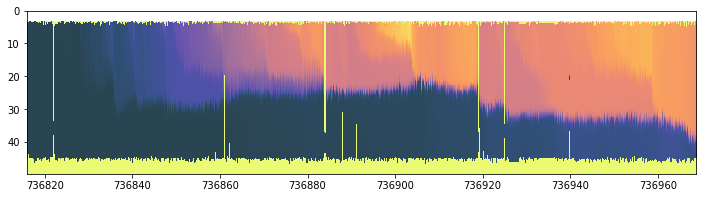

In [286]:
fig, ax = plt.subplots(figsize=(12,3))
plt.imshow(np.transpose(mesh_grid_t), extent=extent, cmap=cmocean.cm.thermal, vmin=4.0, vmax=13.0, aspect='auto', alpha=0.85)


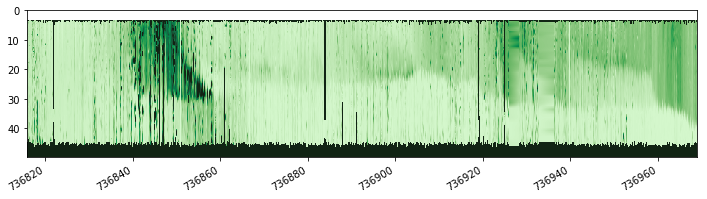

In [287]:
fig, ax = plt.subplots(figsize=(12,3))
plt.imshow(np.transpose(mesh_grid_chl), extent=extent, cmap=cmocean.cm.algae, vmin=0, vmax=15, aspect='auto')
fig.autofmt_xdate()

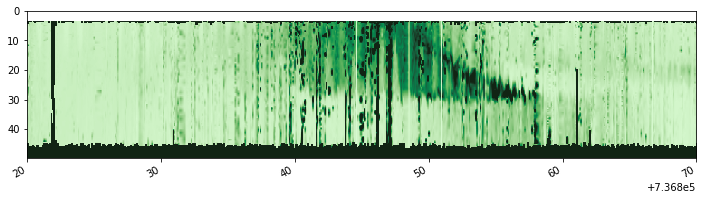

In [288]:
fig, ax = plt.subplots(figsize=(12,3))
plt.imshow(np.transpose(mesh_grid_chl), extent=extent, cmap=cmocean.cm.algae, vmin=0, vmax=15, aspect='auto')
plt.xlim([736820,736870])
fig.autofmt_xdate()

### todo

send cal pressure/time temp/chlor

In [292]:
import pandas as pd
pd.DataFrame(mesh_grid_chl).to_csv("chlor.csv")

In [214]:
t=pd.DataFrame(num2date(time_grid,'Days since 0001-1-1'),columns=['datetime'],dtype='datetime64')